# Soil Type Classification using Convolutional Neural Network

In [146]:
train_data_directory = 'old_dataset/train'
test_data_directory = 'old_dataset/test'

In [147]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

load_model = tf.keras.models.load_model
image = tf.keras.preprocessing.image
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

In [148]:
# initiate data preprocessing tools

# This step processes the images into a format that
# 1. makes the data readable to the model
# 2. provides more training material for the model to train from
# the `training_data_processor` below scales the data so that it can be
# a model input, but also takes each image and augments it so that
# the model can learn from multiple variations of the same image.
# it flips it horizontally, rotates it, shifts it, and more so that 
# the model learns from the soil photo rather than the orientation size
training_data_processor  = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
)
# for the testing images, we don't need to create multiple variatinos
test_data_processor = ImageDataGenerator(rescale=1./255)


# load data into python

training_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (256, 256), # pixels
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 1369 images belonging to 11 classes.
Found 308 images belonging to 11 classes.


## Model building

In [149]:
# choose model parameters
num_conv_layers = 4
num_dense_layers = 3
layer_size = 29 # limit the layer size as we dont want to over fit the model
num_training_epochs = 30
MODEL_NAME = 'final_model'

CLASSES = [
    'alike',
    'clay',
    'dry rocky',
    'grassy',
    'gravel',
    'humus',
    'loam',
    'not',
    'sandy',
    'silty',
    'yellow',
]

In [150]:
# initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convulutional layer
model.add(Conv2D(layer_size, (3,3), input_shape=(256, 256, 3)))
model.add(Activation('relu')) # rectified linear unit
model.add(MaxPooling2D(pool_size=(2,2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# output layer
model.add(Dense(len(CLASSES)))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# use the data already loaded to train/tune the model
model_results = model.fit(
    training_data,
    epochs = num_training_epochs, 
    validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

Epoch 1/30
43/43 [==============================] - 74s 2s/step - loss: 1.8641 - accuracy: 0.4514 - val_loss: 2.2623 - val_accuracy: 0.2370
Epoch 2/30
43/43 [==============================] - 76s 2s/step - loss: 1.1723 - accuracy: 0.6077 - val_loss: 1.4940 - val_accuracy: 0.3864
Epoch 3/30
43/43 [==============================] - 76s 2s/step - loss: 0.9945 - accuracy: 0.6618 - val_loss: 1.3173 - val_accuracy: 0.4448
Epoch 4/30
43/43 [==============================] - 80s 2s/step - loss: 0.8432 - accuracy: 0.7056 - val_loss: 1.5543 - val_accuracy: 0.4903
Epoch 5/30
43/43 [==============================] - 78s 2s/step - loss: 0.8042 - accuracy: 0.7056 - val_loss: 1.0661 - val_accuracy: 0.5682
Epoch 6/30
 1/43 [..............................] - ETA: 1:38 - loss: 0.6912 - accuracy: 0.8125

KeyboardInterrupt: 

## Model Summary

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 254, 254, 22)      616       
                                                                 
 activation_63 (Activation)  (None, 254, 254, 22)      0         
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 127, 127, 22)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 125, 125, 22)      4378      
                                                                 
 activation_64 (Activation)  (None, 125, 125, 22)      0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 62, 62, 22)       0         
 g2D)                                                

## Evaluation

In [ ]:
test_result = model.evaluate(testing_data)
print(test_result)

10/10 [==============================] - 3s 282ms/step - loss: 0.4096 - accuracy: 0.8604
[0.4095695912837982, 0.8603895902633667]


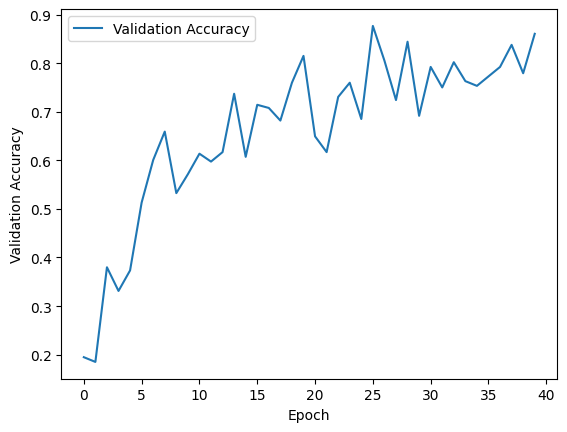

In [ ]:
import pandas as pd

training_dataframe = pd.DataFrame(model_results.history)
plt.plot(training_dataframe['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

10/10 [==============================] - 3s 281ms/step


Text(50.722222222222214, 0.5, 'Truth')

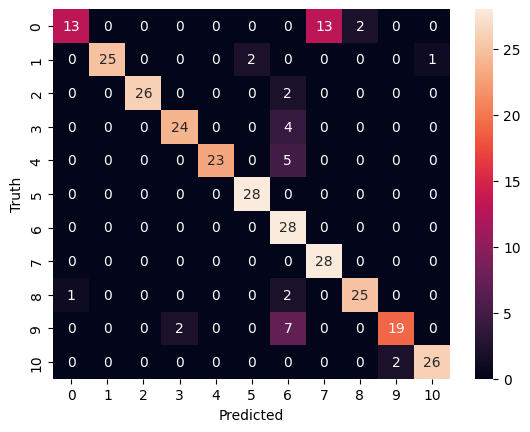

In [ ]:
y_predicted = model.predict(testing_data)
y_predicted = [x.argmax() for x in y_predicted]

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(testing_data.classes, y_predicted)

import seaborn as sb

sb.heatmap(matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
def classify(image_fp):
    im = cv2.imread(image_fp) # load the image from the given file path (image_fp)
    plt.imshow(im[:,:,[2,1,0]]) # swap the colors because open-cv swaps the rgb colors
    img = image.load_img(image_fp, target_size = (256, 256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = CLASSES # possible output values
    from tensorflow import keras
    model = keras.models.load_model(f'{MODEL_NAME}.h5')
    predicted_value = model.predict(img_batch)
    
    out  = f"""
                alike:{predicted_value[0][0]:.5f}
                 clay:{predicted_value[0][1]:.5f}
            dry rocky:{predicted_value[0][2]:.5f}
               grassy:{predicted_value[0][3]:.5f}
               gravel:{predicted_value[0][4]:.5f}
                humus:{predicted_value[0][5]:.5f}
                 loam:{predicted_value[0][6]:.5f}
                  not:{predicted_value[0][7]:.5f}
                sandy:{predicted_value[0][8]:.5f}
                silty:{predicted_value[0][9]:.5f}
               yellow:{predicted_value[0][10]:.5f}

    Result: {(predicted_value[0][predicted_value.argmax()] * 100):.2f}% {class_[predicted_value.argmax()]}

    """
  # accuracy: {(accuracy[1]*100):.5f}
  #     loss: {(accuracy[0]*100):.5f}
    return out

1/1 [==============================] - 0s 126ms/step

                alike:0.56538
                 clay:0.00000
            dry rocky:0.00000
               grassy:0.00000
               gravel:0.00126
                humus:0.00001
                 loam:0.00000
                  not:0.27673
                sandy:0.15544
                silty:0.00117
               yellow:0.00000

    Result: 56.54% alike

    


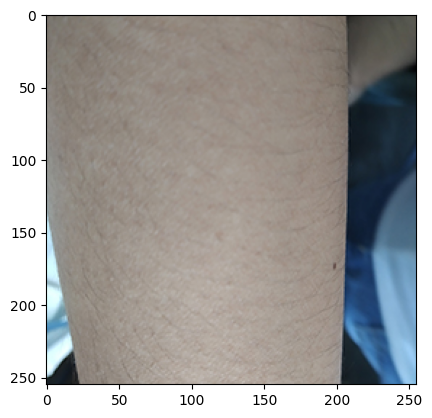

In [ ]:
test_image_file_path = test_data_directory + '/alike/IMG_20221001_105527.jpg'
test_prediction = classify(test_image_file_path)

print(test_prediction)

## Convert final_model.h5 to TFLITE

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model(f'{MODEL_NAME}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f'{MODEL_NAME}.tflite', "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ERICEC~1\AppData\Local\Temp\tmp97xdmes2\assets


INFO:tensorflow:Assets written to: C:\Users\ERICEC~1\AppData\Local\Temp\tmp97xdmes2\assets


1787556

## Converting to tfjs

In [ ]:
import os
os.system("""
tensorflowjs_converter --input_format keras \
	final_model.h5 \
	tfjs""")

0